# Data preparation (Manuel F.)

In [1]:
library(sqldf)
options(scipen=999)

#The working directory should be changed of course
setwd("C:/Users/Manuel/OneDrive/Project_Datascience/R/DMC_2017_task")
train = read.csv("01_Data/train.csv", sep = "|", header = TRUE, dec = ".")
class = read.csv("01_Data/class.csv", sep = "|", header = TRUE, dec = ".")


Warning message:
"package 'sqldf' was built under R version 3.3.3"Loading required package: gsubfn
Warning message:
"package 'gsubfn' was built under R version 3.3.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.3.3"Could not load tcltk.  Will use slower R code instead.
Loading required package: RSQLite
Warning message:
"package 'RSQLite' was built under R version 3.3.3"

## Trend analysis

https://anomaly.io/seasonal-trend-decomposition-in-r/
https://anomaly.io/detect-seasonality-using-fourier-transform-r/

### First approach

**For each product:**
use simple linear regression with y = ß0 + ß1*time

ß1: slope (trend)
ß0: fixed effect (e.g. base cost / base popularity)

-> norm_trend = ß1/ß0

### Second approach

Generally interpretable as time series data.
Time series models compose of three gen

**seasonal:** Describing the seasonal fluctuation of values. Potentially multiple seasonalities.
**trend:** Describing the general trend
**random:** Not able to model random fluctuation

can be used as either additive model:
additive: Y = S+T+R
multiplicative: Y = S*T*R

#### Additive model or multiplicative model?

Time frame of three months is too short for the need to think of general inflation.  
-> Additive model for price

However: A sales increase over the observation periode seems to be occurring.  
-> Maybe additive model for counts? | Effect should not be 

For the sake of implementation simplicity, both used as additive model

#### What episodic element?
Either week, month, fourier transformation

-> For the sake of general reasoning and minimizing computational efford we use 7 days (1 week) as cyclic component.


Normalization of trend attributes by the value average of the label.

In [2]:
#1) Filter price, pid, day
trend = sqldf("select lineID, pid, price, day from train")

#2) generate list of all pids, ordered by occurance
ord_pids = sqldf("select pid from (select count(pid)as cpid, pid 
                 from trend group by pid) as t1 order by t1.cpid desc")


#Definition of a short function for trend decomposition into a data.frame
decomposition = function(x, y, pid, freq = 7){
  ts_tmp = ts(y, frequency = freq)
  decompose_price = stl(ts_tmp, "periodic")
  
  #Cyclic component
  app = data.frame(day = x)
  app["pid"] = pid
  #Normalize to size of price and counts, in order to enable distance equal numbers.
  app["cyclic"] = as.numeric(decompose_price$time.series[,1]/mean(y))
  
  #initializing it with trend 0
  trend_series = c(0)
  
  for(j in c(2:max_day)){
    trend_series = c(trend_series, (decompose_price$time.series[j,2]-decompose_price$time.series[j-1,2]))
  }
  
  #Normalize to size of price and counts, in order to enable distance equal numbers.
  app["trend"] = trend_series/mean(y)
  
  return(app)
}

#OPERATIVE PART OF THE TREND ANALYISIS
#Defining important vectors and data.frames to be filled
trend_price_vars = c()
trend_price_perc = c()
trend_count_vars = c()
trend_count_perc = c()

max_day = max(train$day)
day_df = sqldf("select day from trend group by day")

decomposition_price_df = data.frame(day = integer(), pid = character(), cyclic = double(), trend = double())
decomposition_counts_df = data.frame(day = integer(), pid = character(), cyclic = double(), trend = double())

#Starting the training process
for(i in ord_pids$pid){
  #Select next pid
  tmp = trend[trend$pid == i,]
  
  #3) Average the price values of each product sold on each day       
  trend_tmp = sqldf("select day_df.day, t1.price, t1.counts 
                    from day_df left join (select day, avg(price) as price, count(price) as counts from tmp group by day) as t1 on t1.day = day_df.day")

  #Impute missing counts with 0
  trend_tmp$counts[is.na(trend_tmp$counts)] = 0

  #GENERAL TREND ANALYSIS
  #Calculate the general trend variable for price and counts
  fm = lm(trend_tmp$price ~ trend_tmp$day)
  trend_price_vars = c(trend_price_vars, fm$coefficients[2])
  trend_price_perc = c(trend_price_perc, fm$coefficients[2]/fm$coefficients[1])
  
  fm2 = lm(trend_tmp$counts ~ trend_tmp$day)
  trend_count_vars = c(trend_count_vars, fm$coefficients[2])
  trend_count_perc = c(trend_count_perc, fm$coefficients[2]/fm$coefficients[1])
  
  
  #TREND DECOMPOSITION
  #Trend decomposition price:
  #Check if it is complete (has entry for each day), else skip it
  if(sum(is.na(trend_tmp$price)) == 0){
    
    app = decomposition(trend_tmp$day, trend_tmp$price, i)
    
    #Append to final df
    decomposition_price_df = rbind(decomposition_price_df, app)
  }
  
  #Trend decomposition counts
  app = decomposition(trend_tmp$day, trend_tmp$counts, i)
  decomposition_counts_df = rbind(decomposition_counts_df, app)
  
}

#rm(trend, tmp, trend_tmp)

#JOINING RESULTS INTO A DF
final_trend = sqldf("select trend.lineID, decomposition_counts_df.pid, decomposition_counts_df.day, decomposition_counts_df.cyclic as decomp_cyclic_counts_norm, decomposition_counts_df.trend as decomp_trend_counts_norm 
              from trend join decomposition_counts_df on (decomposition_counts_df.pid = trend.pid and decomposition_counts_df.day = trend.day)")

final_trend = sqldf("select final_trend.*, decomposition_price_df.cyclic as decomp_cyclic_price_norm, decomposition_price_df.trend as decomp_trend_price_norm
              from final_trend left join decomposition_price_df on (final_trend.pid = decomposition_price_df.pid and final_trend.day = decomposition_price_df.day)")



#Add the columns to the overall df

linear_trend_names = c("trend_price", "trend_price_perc", "trend_count", "trend_count_perc")
linear_trend_sum = list(trend_price_vars, trend_price_perc, trend_count_vars, trend_count_perc)

for(i in c(1:length(linear_trend_names))){
  ord_pids[linear_trend_names[i]] = linear_trend_sum[i]
}

final_trend = merge(final_trend, ord_pids, by = "pid")

#-> 511 Missing values, because the products only ocure once, therefore impute with 0.
#Value imputation with 0
final_trend[is.na(final_trend)] = 0
final_trend = subset(final_trend, select = -c(pid, day))

Warning message:
"Quoted identifiers should have class SQL, use DBI::SQL() if the caller performs the quoting."

## ABC-analysis


https://de.wikipedia.org/wiki/ABC-Analyse

**Idea:**
Classifying products as essential for business success.

generally, 80/20 rule:
20% of the products produce 80% of the revenue.

However, there are multiple classification approaches, ranging from ~70-80% of the revenue.

We have used both number of sales and revenue of a product
Changes in classification are significant, so that it varants the approach.


    A     B     C 
 2751  5220 13957 


    A     B     C 
 4597  6661 10670 

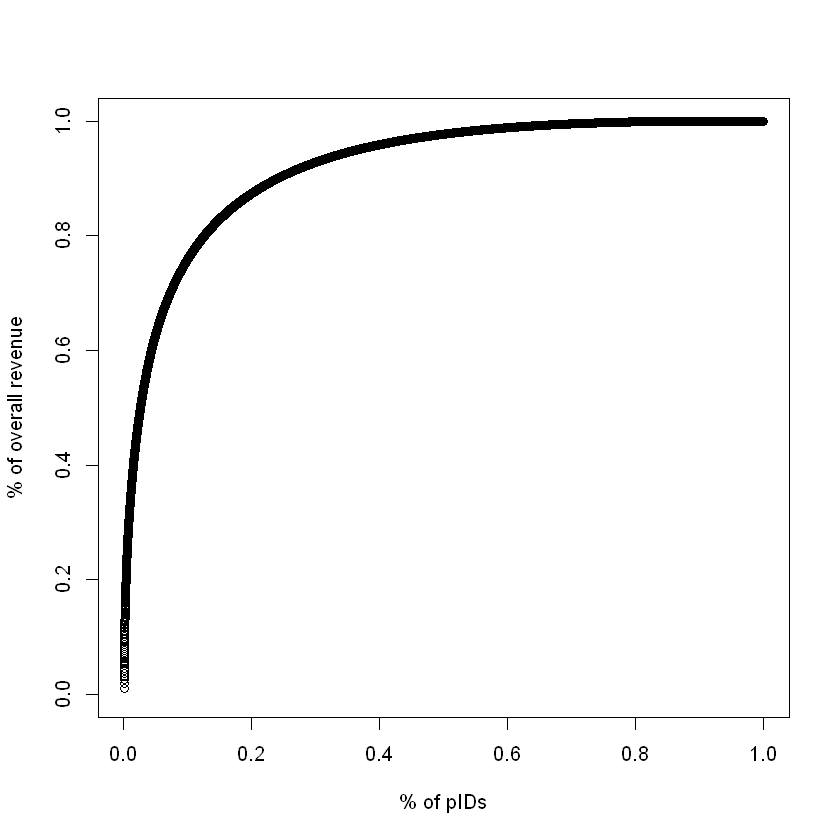

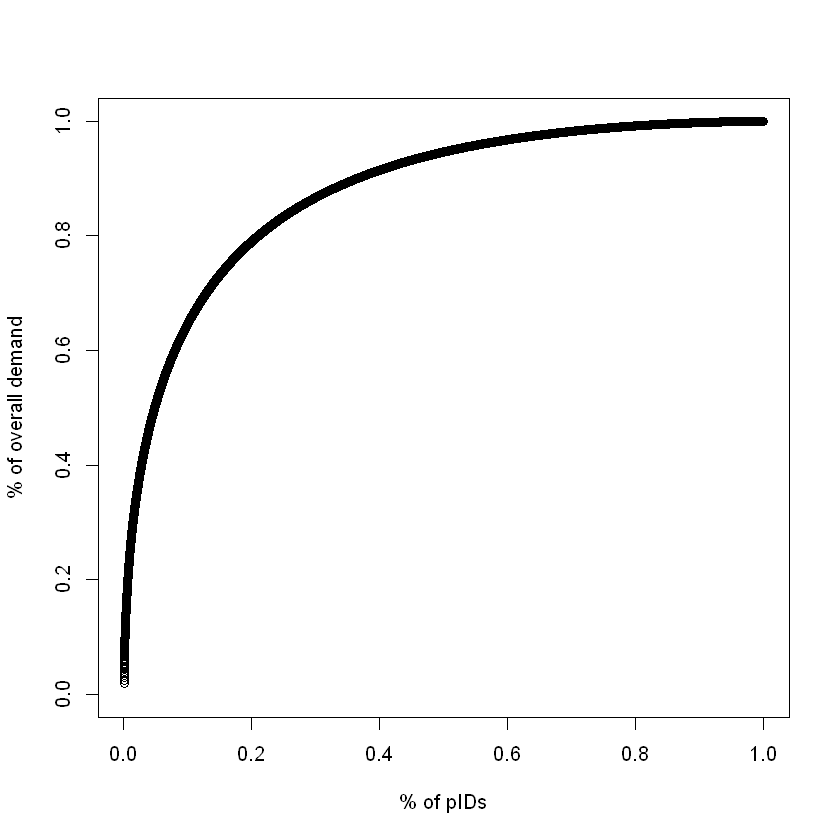

In [3]:
#General sql statement for data generation
abc = sqldf("select *
            from (select pid, count(pid) as demand, sum(revenue) as sumrevenue from train group by pid) as t1
            order by sumrevenue desc")

#ABC analysis revenue
#generate cummulated sum
cs_rev = cumsum(abc$sumrevenue)

abc["cs_rev"] = cs_rev
abc["ABC_rev"] = "A"
abc$ABC_rev[abc$cs_rev > sum(abc$sumrevenue)*0.80] = "B"
abc$ABC_rev[abc$cs_rev > sum(abc$sumrevenue)*0.95] = "C"

table(abc$ABC_rev)
#Frequency occurance checks out


#ABC analysis number of sales
#Order by counts first
abc = abc[order(-abc$demand),]

#generate cummulated sum
cs_dem = cumsum(abc$demand)

abc["cs_dem"] = cs_dem
abc["ABC_dem"] = "A"
abc$ABC_dem[abc$cs_dem > sum(abc$demand)*0.80] = "B"
abc$ABC_dem[abc$cs_dem > sum(abc$demand)*0.95] = "C"

table(abc$ABC_dem)
#Demand is not as stereotypical as revenue, but checks out

#PLOTTING FOR PROOF
#normalize the y axis
norm_cs_rev = cs_rev/sum(abc$sumrevenue)

#Plot the
plot(c(1:nrow(abc))/nrow(abc), norm_cs_rev, xlim = c(0, 1), ylim = c(0, 1), xlab = "% of pIDs", ylab = "% of overall revenue")

norm_cs_dem = cs_dem/sum(abc$demand)
#Plot the ABC Analysis of demand
plot(c(1:nrow(abc))/nrow(abc), norm_cs_dem, xlim = c(0, 1), ylim = c(0, 1), xlab = "% of pIDs", ylab = "% of overall demand")

#Match the classification to the train and class data
final_ABC = sqldf("select train.lineID, abc.ABC_rev, abc.ABC_dem from train left join abc on train.pid = abc.pid")


ABC analysis seems to make sense. However, the allocation of those values is inheritently unbalanced, caused by the selection criterion.


## Additional feature engeneering

In [4]:
#Order may be missinterpreted
names(train)[names(train) == 'order'] = 'ordered'

additonal_features = sqldf("select pid, avg(price) as mean_price, avg(click) as mean_click, avg(basket) as mean_basket, avg(ordered) as mean_order 
      from train group by pid")


## Fixed effects analysis

**Assumption:** Static inherint bias in values based on endogeneitiy.

Fixed effects analysis can be destinguished in
1) Unit fixed effects: Constant (endogenous) values bias of units.
2) Time fixed effects: Constant (endogenous) effects over time on all observation units.

-> Endogeneity & resulting autocorrelation leads to bias in certain models.

**However:** Main improvement is in the correct interpretability of the model and not necessary classification quality!

Can be tested with a **Hausman test**:

**H_0:** 	No correlation between the individual effects and the indepentent attribute. (independence of residuals & dependent variable)  
**H_1:**    Correlation of indiviudual effects and at least one independent attribute

**H_0 rejected**     -> Fixed effects model  
**H_0 not rejected** -> Random effects model


Two most common approaches (Multiple approaches):
- Within-transformation: Subtract the attribute mean of the product of each product value. -> Constant effects will be removed. 
- Dummy coding approach: Handling Nominal values. Constant values will be values with the constant effect in regression.

**Conclusion:**
Within transformation may not be use-full / necessary in our case!
Approaches can be used to destinguish the information source if necessary.

**Example:**
price has information about price fluctuation, potentiall production costs, demand etc.
-> within transformation: only price fluctuation left.

In [5]:
final = sqldf("select train.lineID, (train.price -  af.mean_price) as price_fluctuation, af.mean_click, af.mean_basket, af.mean_order 
      from train join additonal_features  as af on train.pid = af.pid")

df_list <- list(final_trend, final_ABC, final)
final = Reduce(function(x, y) merge(x, y, by = "lineID", all=TRUE), df_list, accumulate=FALSE)

summary(final)
    
write.csv(final, "final.csv")

     lineID        decomp_cyclic_counts_norm decomp_trend_counts_norm
 Min.   :      1   Min.   :-0.94694          Min.   :-5.956881       
 1st Qu.: 689002   1st Qu.:-0.09014          1st Qu.:-0.036983       
 Median :1378002   Median : 0.07007          Median : 0.004361       
 Mean   :1378002   Mean   : 0.08027          Mean   : 0.012958       
 3rd Qu.:2067003   3rd Qu.: 0.20065          3rd Qu.: 0.056827       
 Max.   :2756003   Max.   : 6.26874          Max.   : 9.516955       
 decomp_cyclic_price_norm decomp_trend_price_norm  trend_price       
 Min.   :-0.06812314      Min.   :-0.07511006     Min.   :-6.050000  
 1st Qu.: 0.00000000      1st Qu.: 0.00000000     1st Qu.: 0.000000  
 Median : 0.00000000      Median : 0.00000000     Median : 0.000392  
 Mean   :-0.00001678      Mean   :-0.00002157     Mean   : 0.003043  
 3rd Qu.: 0.00000000      3rd Qu.: 0.00000000     3rd Qu.: 0.003855  
 Max.   : 0.08473138      Max.   : 0.09311116     Max.   : 1.530000  
 trend_price_perc   

In [ ]:
#Clear workspace
rm(list=ls())